# Hyperparameter tunning for LightGBM

We will tune the below parameters

 * n_estimators     : Number of boosted trees to fit
 * num_leaves       : Maximum tree leaves for base learners
 * max_depth        : Maximum tree depth for base learners, <=0 means no limit
 * min_child_weight : Minimum sum of instance weight (hessian) needed in a child (leaf).
 * subsample        : Subsample ratio of the training instance.

In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta

from sklearn.metrics import mean_squared_log_error as msle

In [ ]:
# read the final data set with the newly created features
data = pd.read_csv('final_data.csv')
data.head()

In [ ]:
data = data.drop(columns =['Total_Featured_Products',
       'Total_Displayed_Products', 'NPS1', 'NPS2', 'NPS3', 'QRTUNT1',
       'QRTUNT2', 'QRTUNT3', 'QRTUNT4'])

In [ ]:
data.head(2)

In [ ]:
# convert the WEEK_END_DATE to datetime format
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [ ]:
# let's look at all the features we have in the first row.
data.loc[0]

In [ ]:
# we will drop the 2 date columns,  2_MONTH_BEFORE and 1_WEEK_BEFORE as they are not required now.
data = data.drop(columns=['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [ ]:
data.head(2)

We will use the same validation_df function to create the validation sets.

In [ ]:
# create an array of unique week dates
week = data.WEEK_END_DATE.unique()

In [ ]:
# check for the null values
data.isna().sum().sum()

In [11]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [12]:
# we will use the same combination of 2 month training data with 14 validation sets
validation_df(data, week, no_of_months=2, no_of_validation= 14)

,no_days_train,set_no,test_shape,test_week,train_end,train_shape,train_start,validate_week,validation_shape
0,56 days,set1,1642,2011-09-28,2011-08-31,13089,2011-07-13,2011-09-14,1640
1,56 days,set2,1638,2011-09-21,2011-08-24,13102,2011-07-06,2011-09-07,1632
2,56 days,set3,1640,2011-09-14,2011-08-17,13101,2011-06-29,2011-08-31,1629
3,56 days,set4,1632,2011-09-07,2011-08-10,13101,2011-06-22,2011-08-24,1640
4,56 days,set5,1629,2011-08-31,2011-08-03,13109,2011-06-15,2011-08-17,1638
5,56 days,set6,1640,2011-08-24,2011-07-27,13108,2011-06-08,2011-08-10,1631
6,56 days,set7,1638,2011-08-17,2011-07-20,13108,2011-06-01,2011-08-03,1640
7,56 days,set8,1631,2011-08-10,2011-07-13,13112,2011-05-25,2011-07-27,1637
8,56 days,set9,1640,2011-08-03,2011-07-06,13104,2011-05-18,2011-07-20,1635
9,56 days,set10,1637,2011-07-27,2011-06-29,13101,2011-05-11,2011-07-13,1639


# create train and validation set from the above as evaluation data sets as done for xgboost and catboost

In [13]:
# train validation set
def get_evaluation_sets(df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['validate_week'])
        # get the train data
        train_data = data[(data.WEEK_END_DATE >= df.loc[row]['train_start']) & (data.WEEK_END_DATE <= df.loc[row]['train_end'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

In [14]:
# store the train and validation sets in a list
evaluation_set = get_evaluation_sets(validation_df(data, week, no_of_months=2, no_of_validation=14))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00
2011-07-13 00:00:00
2011-07-06 00:00:00
2011-06-29 00:00:00
2011-06-22 00:00:00
2011-06-15 00:00:00


In [15]:

# function to calculate the RMSLE
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))


# custom evaluation metric function for the XGBoost
def custom_eval(preds, dtrain):
  
    #print(dtrain.astype(int))
    #print(preds)
    #return
    labels = dtrain.get_label().astype(np.int)
    #labels  = dtrain.astype(int)
    preds = preds.clip(min=0)
    
    return [('rmsle', get_msle(labels, preds))]


In [ ]:
 model = lgb.LGBMRegressor(boosting_type = 'gbdt',
                                     n_estimators = 100,
                                     learning_rate = 0.01,
                                     n_jobs=-1,
                                     random_state=0,
                                     objective='regression')

In [ ]:
model.fit(train_data_x, train_data_y,eval_set= e_set, verbose=False)

# N_estimators

In [17]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in (range(min_r, max_r, 100)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            
            # define the XGBRegressor Model 
            model = lgb.LGBMRegressor(boosting_type = 'gbdt',
                                     n_estimators = n_est,
                                     learning_rate = 0.01,
                                     n_jobs=-1,
                                     random_state=0,
                                     bagging_fraction = 0.33,
                                     bagging_freq =5,
                                     feature_fraction =0.04,
                                     objective='regression')
            # fit the model
            model.fit(train_data_x, train_data_y,eval_set= e_set, verbose=False)
            
            # predict on train and valid data
            predict_train = model.predict(train_data_x).clip(min=0)
            predict_valid = model.predict(valid_data_x).clip(min=0)
            
            # get the rmsle on train and valid
            train_rmsle = get_msle(train_data_y, predict_train)
            valid_rmsle = get_msle(valid_data_y, predict_valid)
            
            SCORE_TRAIN.append(train_rmsle)
            SCORE_VALID.append(valid_rmsle)
                                 
        # calculate the mean rmsle on train and valid
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With N_ESTIMATORS:\t'+ str(n_est) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train) + "\tMEAN RMSLE VALID: "+str(mean_score_valid))
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
        

    return pd.DataFrame.from_dict(results)

In [18]:
n_estimators_result = get_n_estimators(evaluation_set,min_r = 100, max_r = 1000)

With N_ESTIMATORS:	100	MEAN RMSLE TRAIN:	0.9027287502667287	MEAN RMSLE VALID: 0.9016880554751585
With N_ESTIMATORS:	200	MEAN RMSLE TRAIN:	0.8234433023711276	MEAN RMSLE VALID: 0.8280657559448626
With N_ESTIMATORS:	300	MEAN RMSLE TRAIN:	0.739666200652768	MEAN RMSLE VALID: 0.7522268753177698
With N_ESTIMATORS:	400	MEAN RMSLE TRAIN:	0.6814733874471618	MEAN RMSLE VALID: 0.6992403302454019
With N_ESTIMATORS:	500	MEAN RMSLE TRAIN:	0.6344683247186403	MEAN RMSLE VALID: 0.6574972821582191
With N_ESTIMATORS:	600	MEAN RMSLE TRAIN:	0.5960502668548344	MEAN RMSLE VALID: 0.6231081524984726
With N_ESTIMATORS:	700	MEAN RMSLE TRAIN:	0.5750171644579353	MEAN RMSLE VALID: 0.604195878787292
With N_ESTIMATORS:	800	MEAN RMSLE TRAIN:	0.5648239555401261	MEAN RMSLE VALID: 0.5957058087666517
With N_ESTIMATORS:	900	MEAN RMSLE TRAIN:	0.5615916700484078	MEAN RMSLE VALID: 0.5952763640159174


In [21]:
n_estimators_result

,mean_rmsle_train,mean_rmsle_valid,n_estimators
0,0.902729,0.901688,100
1,0.823443,0.828066,200
2,0.739666,0.752227,300
3,0.681473,0.699240,400
4,0.634468,0.657497,500
5,0.596050,0.623108,600
6,0.575017,0.604196,700
7,0.564824,0.595706,800
8,0.561592,0.595276,900


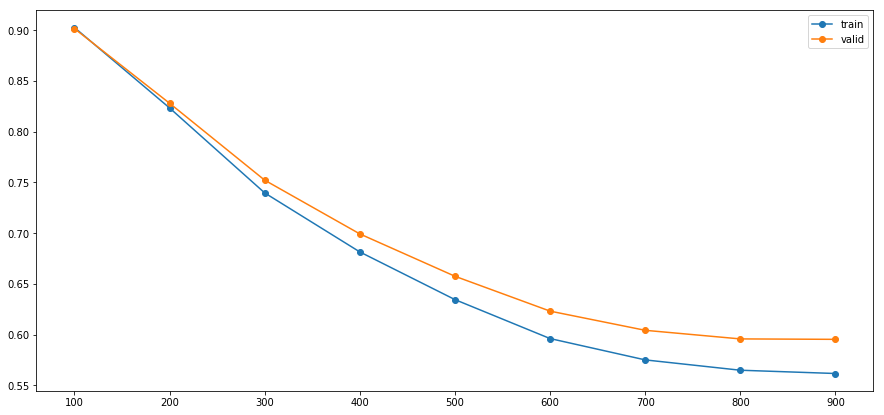

In [22]:
plt.figure(figsize=(15,7))
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_train'], marker='o', label= 'train')
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_valid'], marker='o', label= 'valid')
plt.legend();

In [ ]:
n_estimators_result = get_n_estimators(evaluation_set,min_r = 100, max_r = 1000)